In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")
import random
random.seed(203)
import numpy as np
np.random.seed(345)
from rich import print

In [2]:
from pathlib import Path

# Running a single-thread negotiation

NegMAS has several built-in negotiation `Mechanisms`, negotiation agents (`Negotiators`), and `UtilityFunctions`. You can use these to run negotiations as follows.

Imagine a buyer and a seller negotiating over the price of a single object. First, we make an issue "price" with 50 discrete values. Note here, it is possible to create multiple issues, but we will not include that here. If you are interested, see the [NegMAS documentation](https://negmas.readthedocs.io/en/latest/tutorials/01.running_simple_negotiation.html) for a tutorial. (1)

In [3]:
from negmas import (
    make_issue,
    SAOMechanism,
   TimeBasedConcedingNegotiator,
)
from anl.anl2024.negotiators import Boulware, Conceder, RVFitter
from negmas.preferences import LinearAdditiveUtilityFunction as UFun
from negmas.preferences.value_fun import IdentityFun, AffineFun
import matplotlib.pyplot as plt


# create negotiation agenda (issues)
issues = [
    make_issue(name="price", values=50),
]

# create the mechanism
session = SAOMechanism(issues=issues, n_steps=20)

The negotiation protocol in NegMAS is handled by a `Mechanism` object. Here we instantiate a`SAOMechanism` which implements the [Stacked Alternating Offers Protocol](https://ii.tudelft.nl/~catholijn/publications/sites/default/files/Aydogan2017_Chapter_AlternatingOffersProtocolsForM.pdf). In this protocol, negotiators exchange offers until an offer is accepted by all negotiators (in this case 2), a negotiators leaves the table ending the negotiation or a time-out condition is met. In the example above, we use a limit on the number of rounds of `20` (a step of a mechanism is an executed round).

Next, we define the utilities of the seller and the buyer. The utility function of the seller is defined by the ```
IdentityFun```  which means that the higher the price, the higher the utility function. The buyer's utility function is reversed. The last two lines make sure that utility is scaled between 0 and 1.

In [4]:
seller_utility = UFun(
    values=[IdentityFun()],
    outcome_space=session.outcome_space,
)

buyer_utility = UFun(
    values=[AffineFun(slope=-1)],
    outcome_space=session.outcome_space,
)

seller_utility = seller_utility.normalize()
buyer_utility = buyer_utility.normalize()


Then we add two agents with a boulware strategy. The negotiation ends with status overview. For example, you can see if the negotiation timed-out, what agreement was found, and how long the negotiation took. Moreover, we output the full negotiation history. For a more visual representation, we can plot the session. This shows the bidding curve, but also the proximity to e.g. the Nash point.

SAOState(
    running=False,
    waiting=False,
    started=True,
    step=18,
    time=0.004048299975693226,
    relative_time=0.9047619047619048,
    broken=False,
    timedout=False,
    agreement=(23,),
    results=None,
    n_negotiators=2,
    has_error=False,
    error_details='',
    erred_negotiator='',
    erred_agent='',
    threads={},
    last_thread='',
    current_offer=(23,),
    current_proposer='seller-2515eb40-48b6-4a82-9178-804c70cfd3af',
    current_proposer_agent=None,
    n_acceptances=2,
    new_offers=[('seller-2515eb40-48b6-4a82-9178-804c70cfd3af', (23,))],
    new_offerer_agents=[None],
    last_negotiator='seller',
    current_data=None,
    new_data=[('seller-2515eb40-48b6-4a82-9178-804c70cfd3af', None)]
)

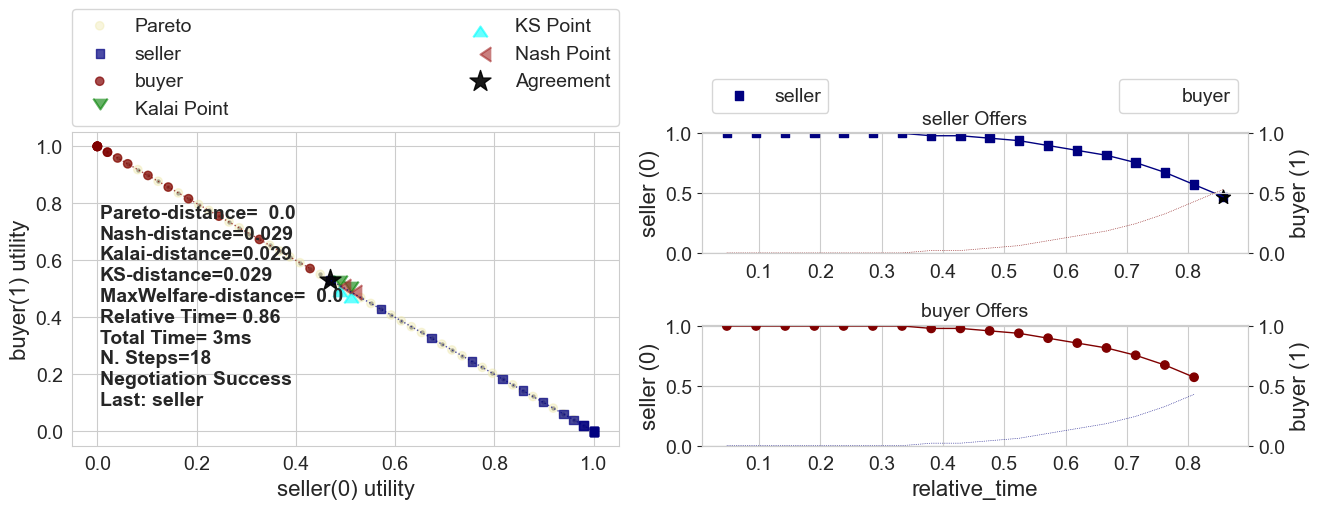

In [5]:
# create and add agent A and B
session.add(Boulware(name="seller"), ufun=seller_utility)
session.add(Boulware(name="buyer"), ufun=buyer_utility)

# run the negotiation and show the results
print(session.run())
session.plot(ylimits=(0.0, 1.01), show_reserved=False, mark_max_welfare_points=False)
plt.show()


# Running a Multi-deal negotiation

ANL 2025's challenge is to develop agents capable of negotiating sequentially a set of interrelated deals (Multi-deal negotiation). You can create and run a multi-deal negotiation using special tools provided by the anl2025 package.

## A random multideal-session

In [6]:
from anl2025 import make_multideal_scenario

scenario = make_multideal_scenario(nedges=8)

**What just happened?**

We created a random multi-deal session with one center agent and 8 edge agents. The center agent negotiates with all the edge agents. Each one of these negotiations is called a **negotiation thread** and the whole set is called a **multideal negotiation**.

The following figure shows the structure of a typical such scenario (with 8 instead of 10 edge agents). Each one of the **edge agents** has its own utility function $e_i$ and is in the same kind of situation as the buyer and seller in the previous example.

The **center agent** faces a different challenge. It has one utility function defined for each **negotiation thread** called a **side utility function** ($s_i$). The overall utility of the center agent is some function (called the **combination function**) of the side utilities it gets in all the negotiation threads. 

```{note}
In ANL 2025, the center agent negotiates with the side agents sequentially. It completes a negotiation with one edge agent before starting the next negotiation with the next edge agent. At no time does the center agent have multiple negotiation threads running at the same time. 
```

The following figure shows the situation:

![Example](Slide2.jpeg)

The function `make_multideal_scenario` creates such a scenario. The combination function used by default is `max` (i.e. the center get the maximum utlility it gets in all negotiations) but you can easily change it. See the full documentation of `make_multideal_scenario` in the Reference for more details of how to control all aspects of scenario  generation.

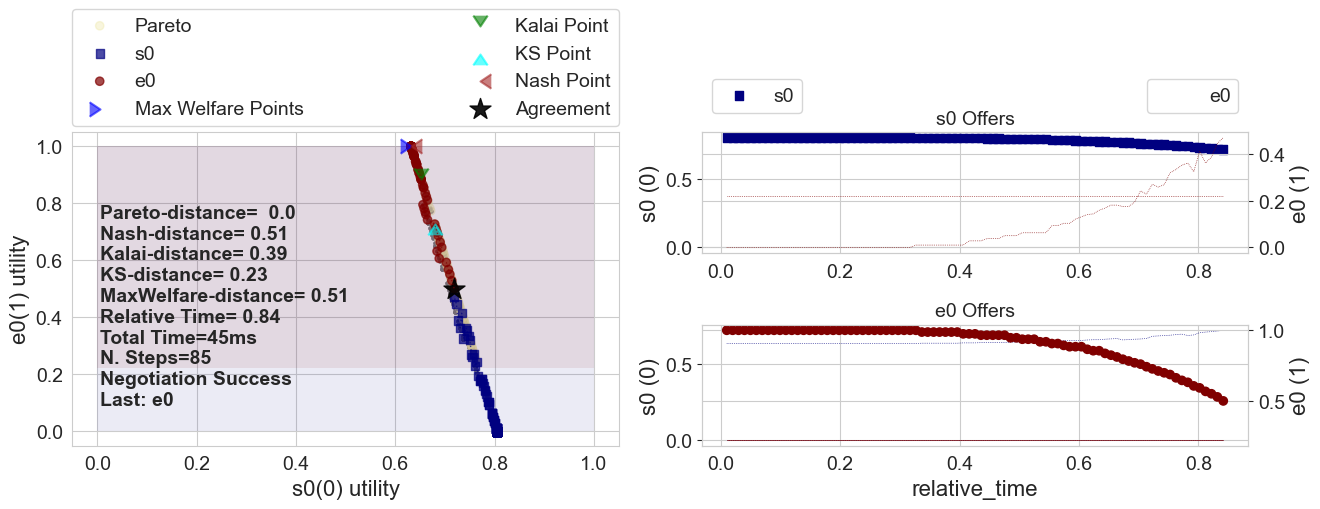

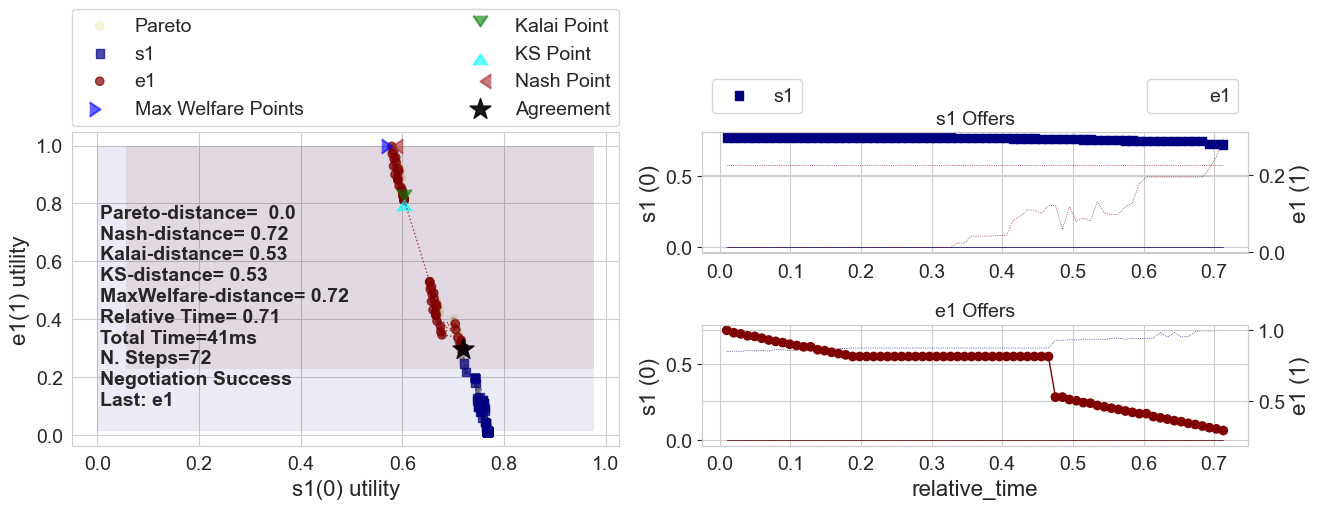

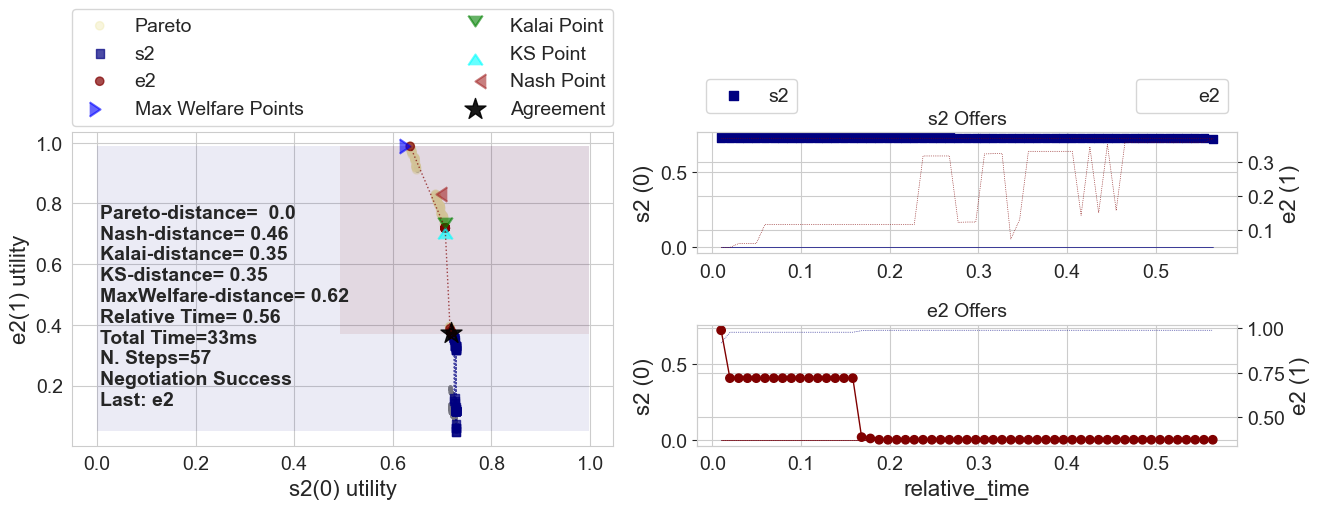

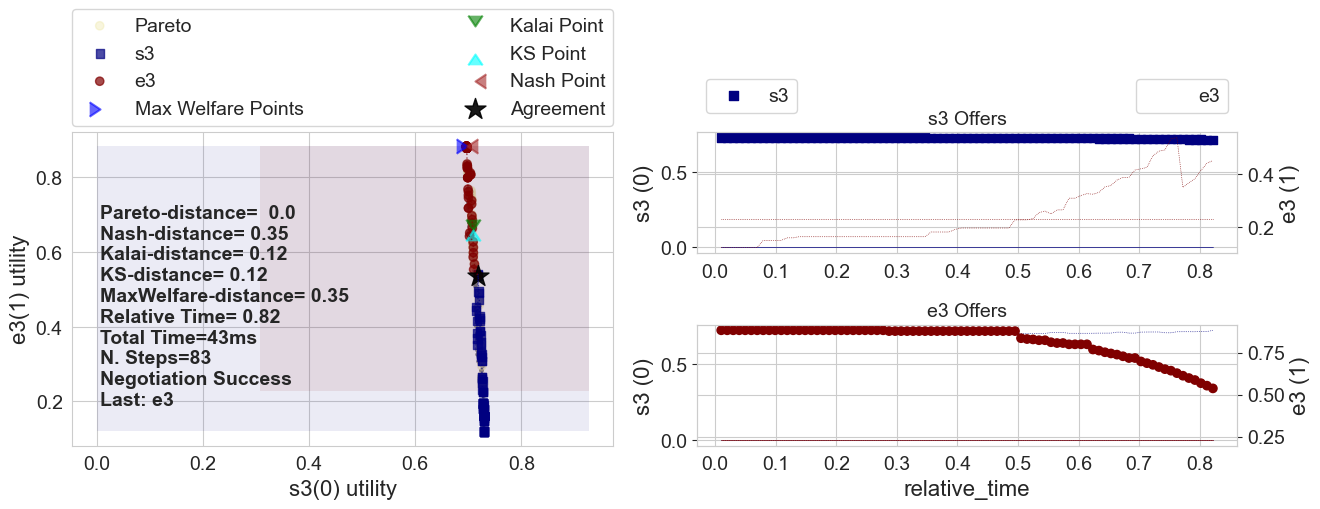

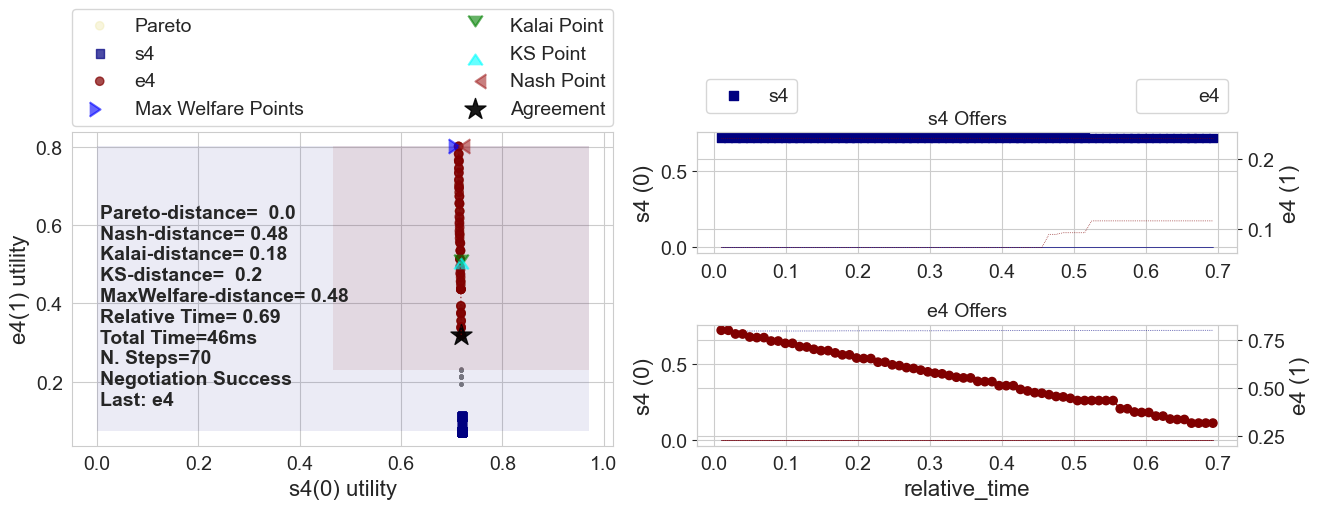

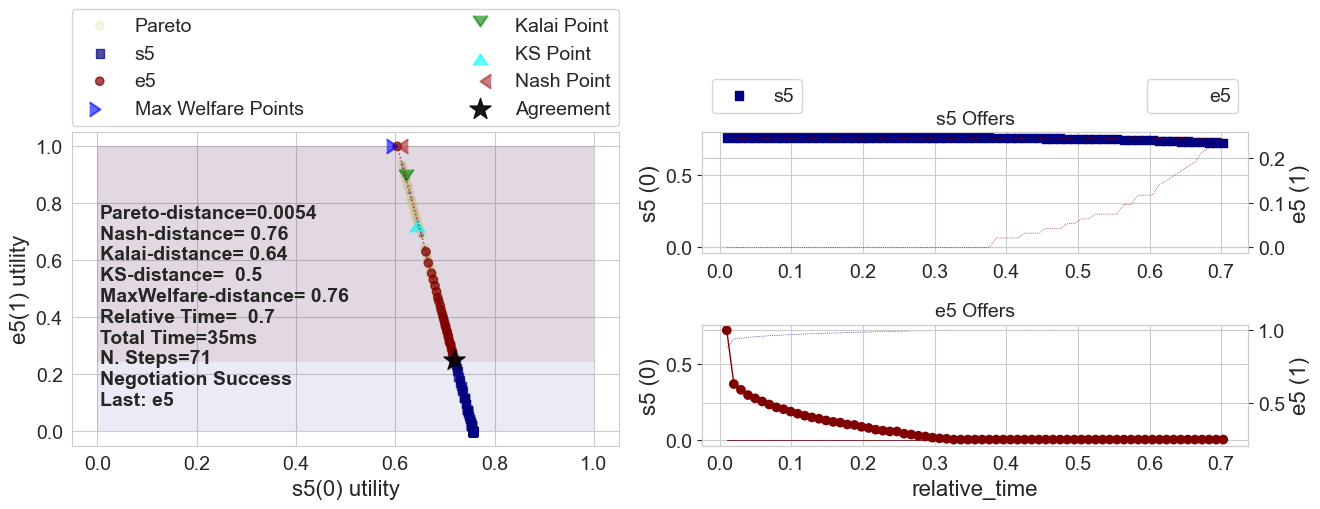

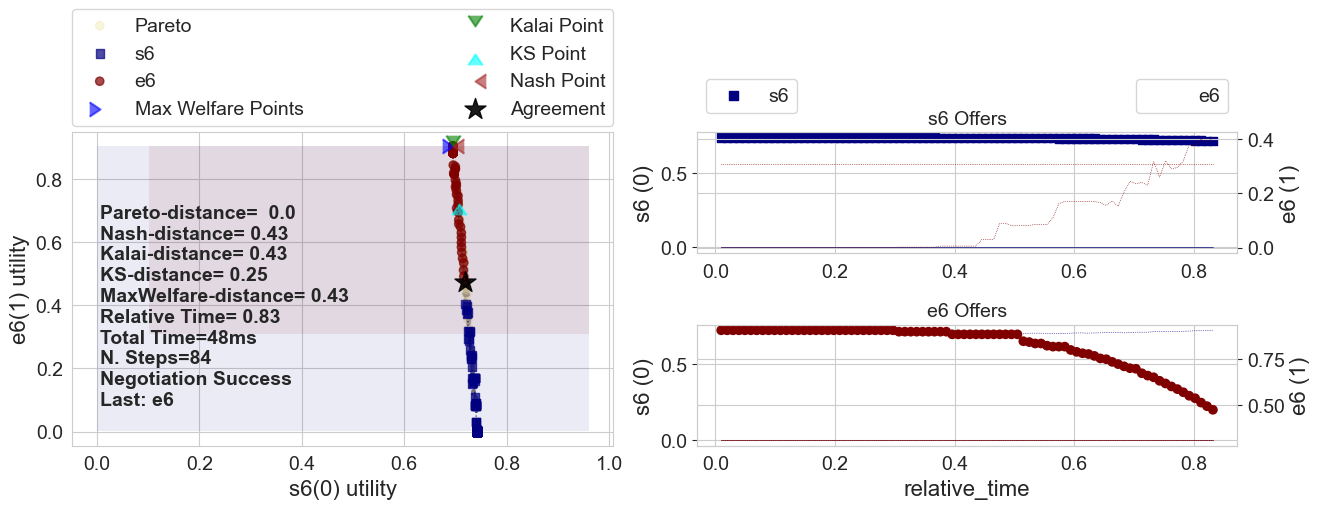

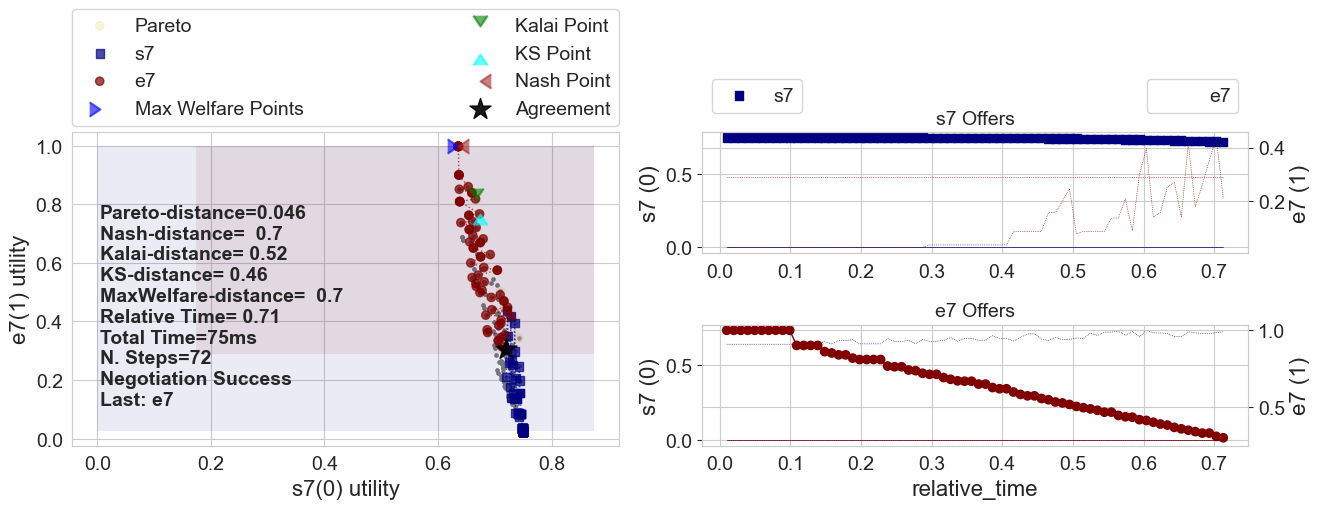

In [7]:
from anl2025 import run_session
results = run_session(scenario)


In [8]:
print(f"Center utility: {results.center_utility}")
print(f"Edge Utilities: {results.edge_utilities}")

Center utility: 0.6950491191272049

Edge Utilities: [0.5006916644920066, 0.2947158934301477, 0.3723437914967285, 0.536544338413959, 
0.31903386564075864, 0.2488242204543755, 0.4726159991815505, 0.3048364027928087]

### A dinners' scheduling session

In the previous example, the center utility function was defined in terms of individual side utility functions (one per negotiation threads). A more general case is when the center utility function is defined directly in terms of the outcomes of negotiation threads without locally defined utility functions. The following figure shows an example of this kind of scenario:

![Global Utility Function Example](Slide1.jpeg)

The `anl2025` package allows you to create such scenarios using the `LambdaCenterUFun` class (See Reference). One class of these sceanrios is the **Dinners** scenarios in which one person (center agent) is negotiating with her friends (edge agents) about the day to go out for dinner. Each friend has her own utility function for different days. The cener agent has a utility for each combination of agreements (i.e. she may prefer to go out once every night except in Tuesdays,

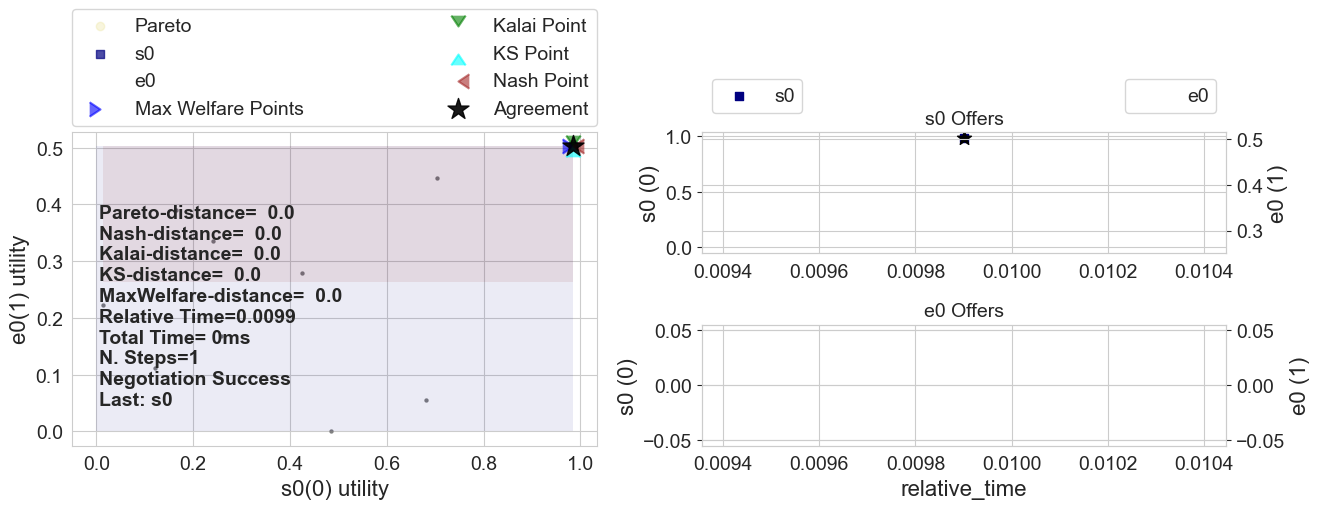

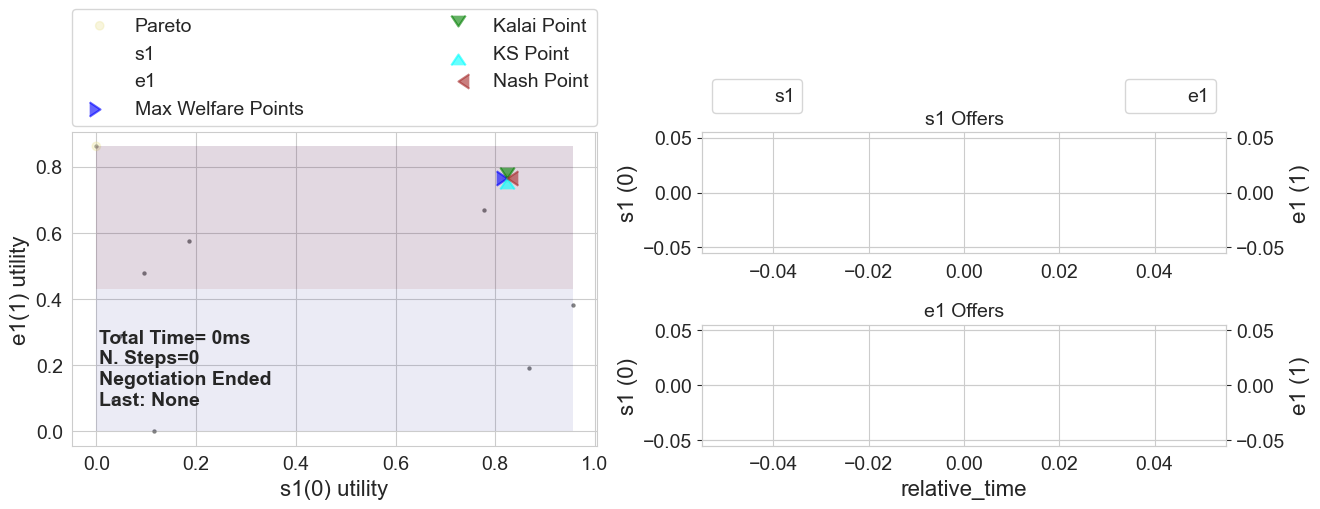

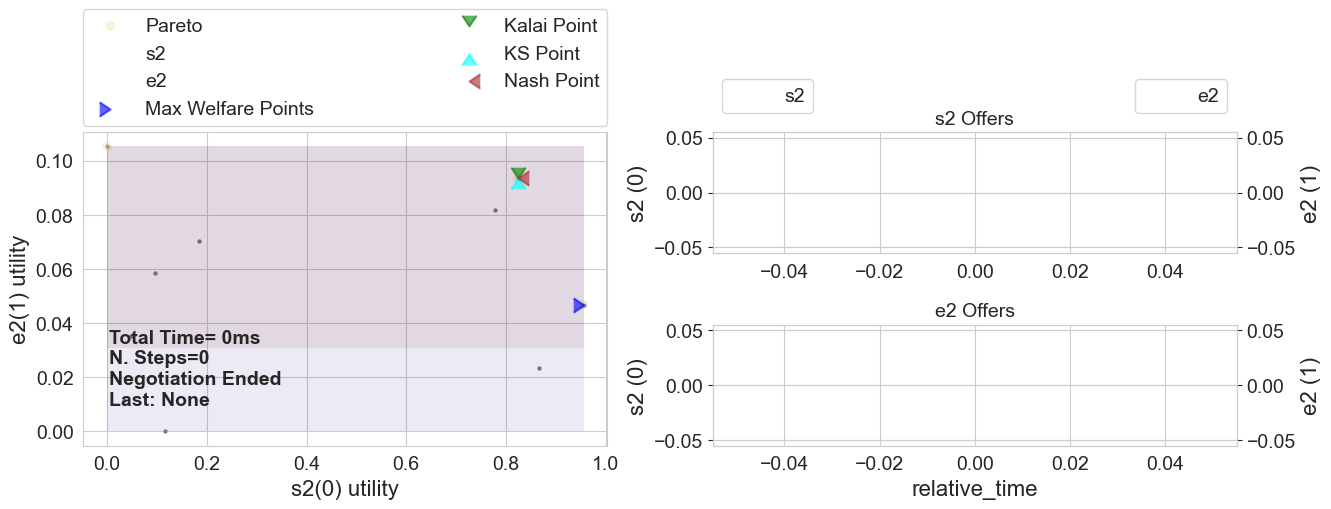

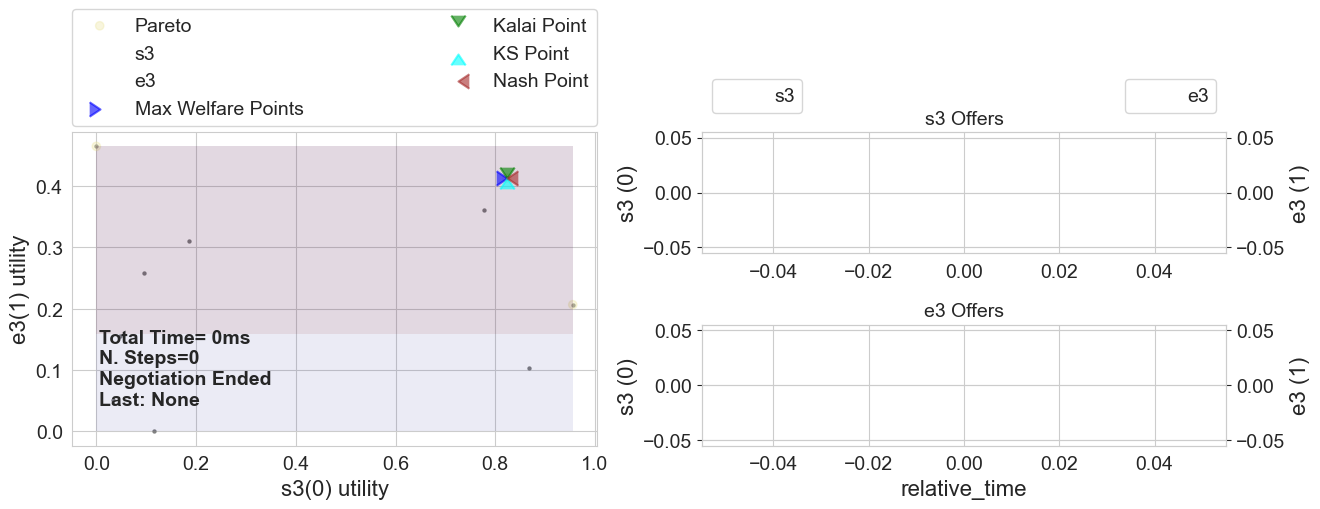

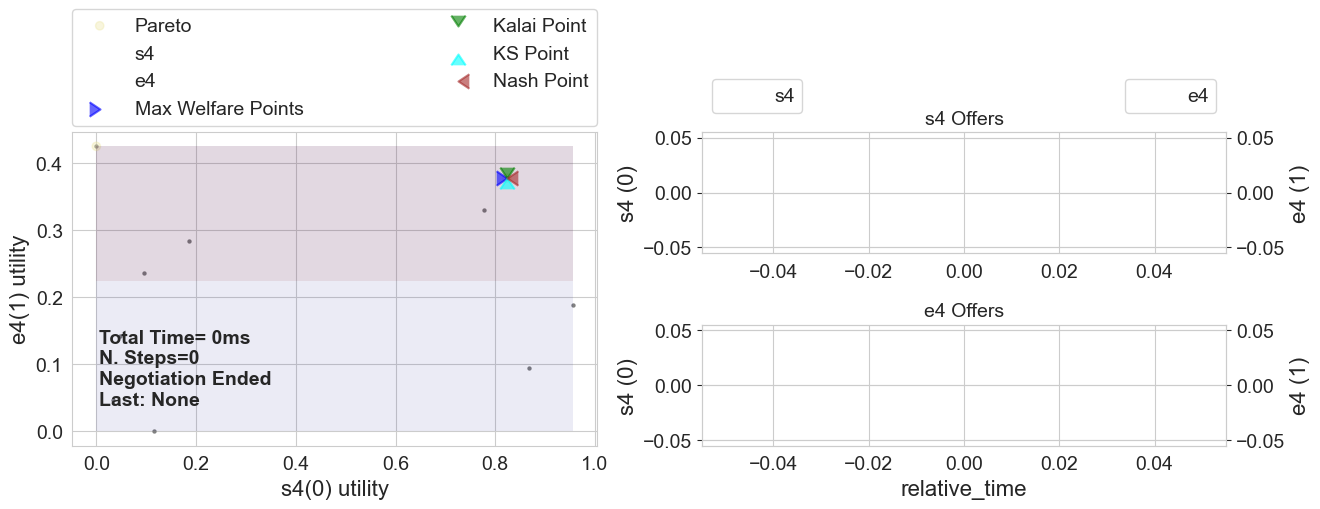

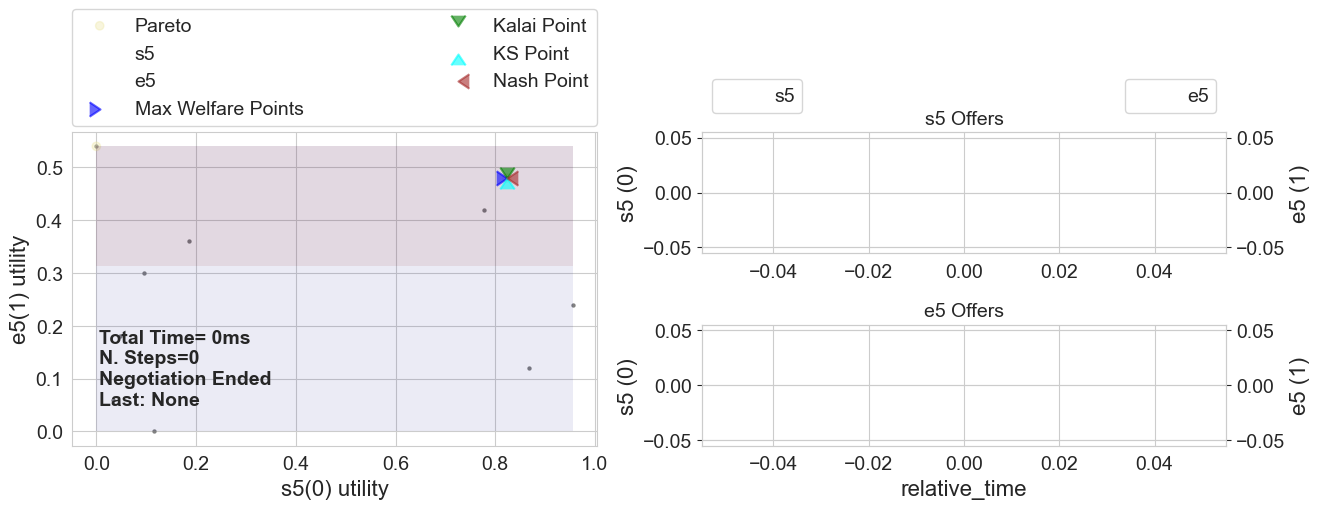

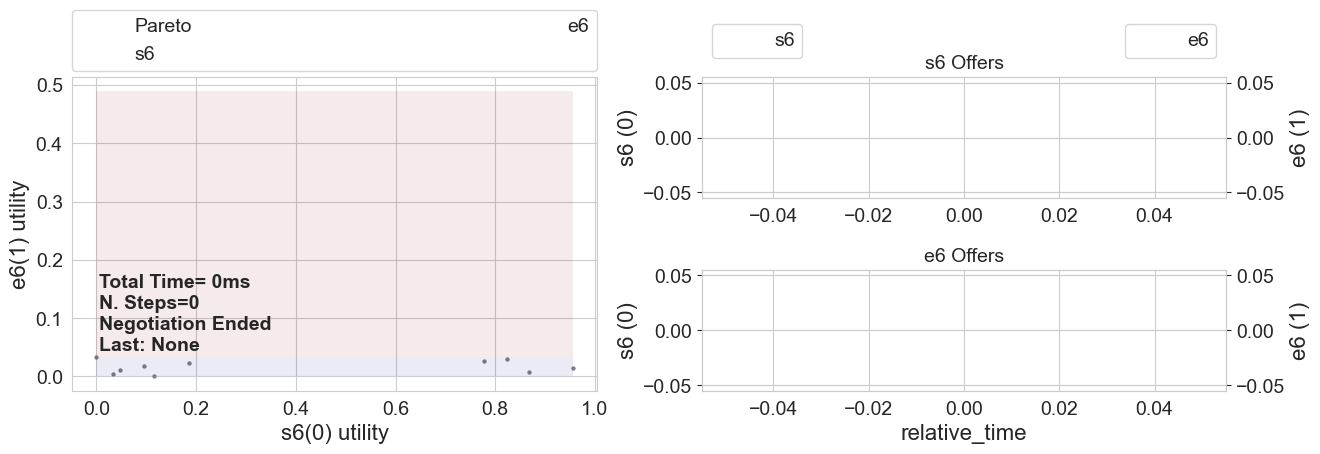

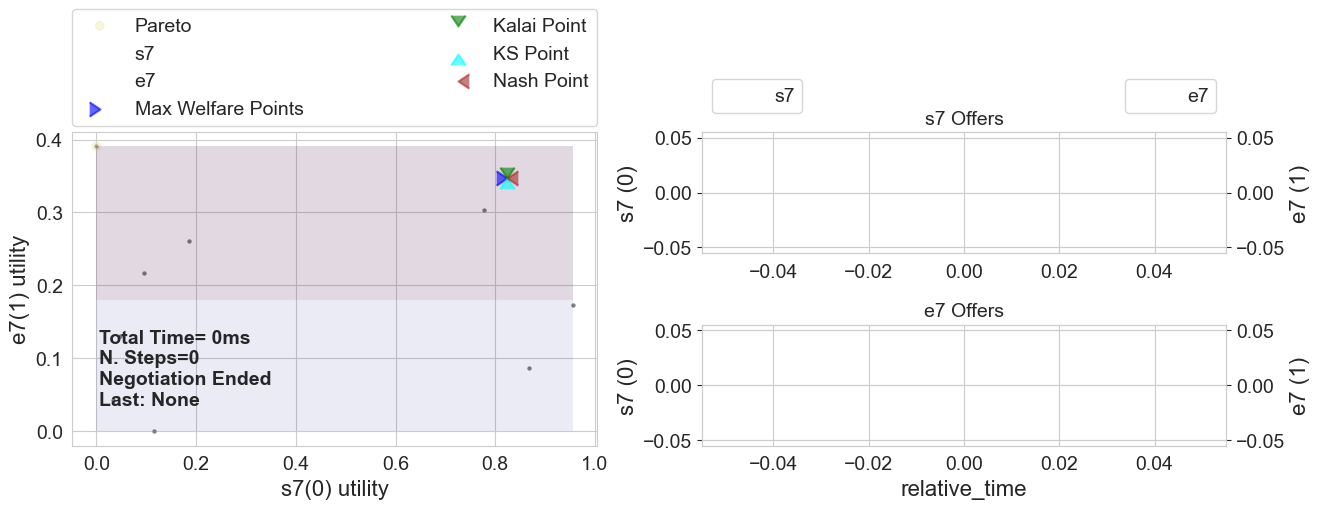

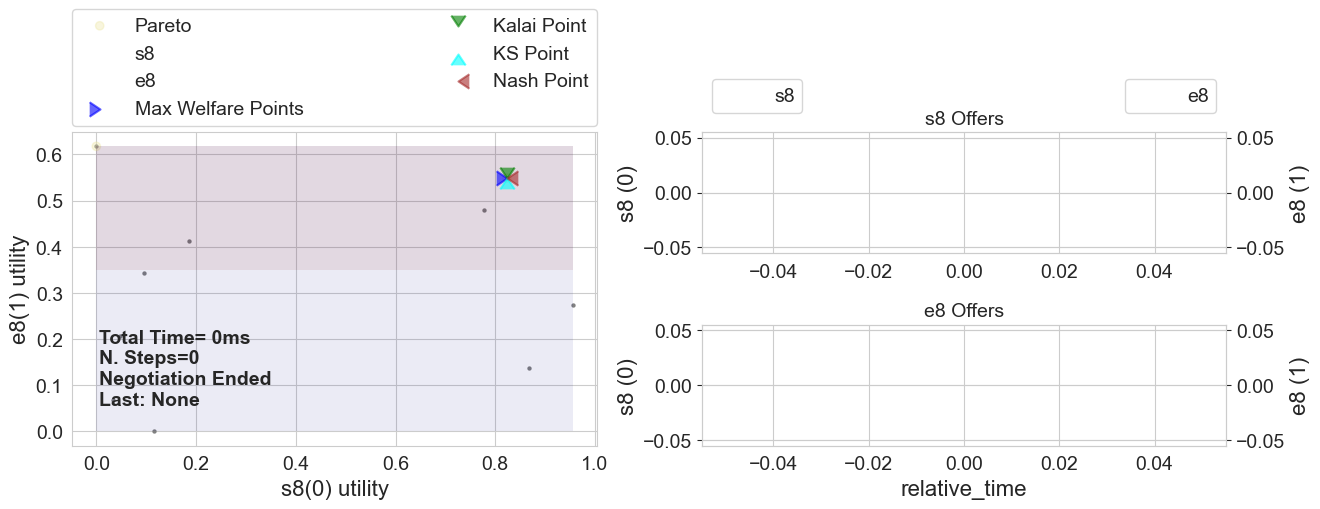

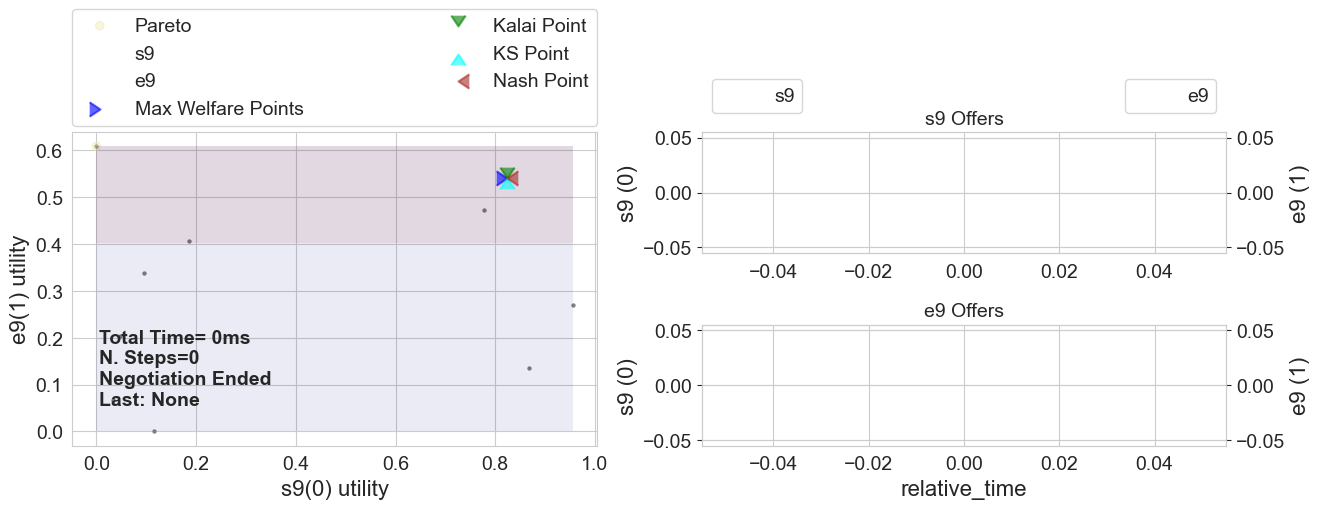

In [9]:
from anl2025 import make_dinners_scenario

results = run_session(make_dinners_scenario(n_friends=10))